In [1]:
import numpy as np
import pandas as pd
import autograd.numpy as anp

import csv
import random
import time, array

import pymop

from operator import mul
from math import sin, cos, pi, exp, e, sqrt, factorial

from functools import reduce

from deap import base, creator, tools, algorithms, benchmarks 
from deap.benchmarks.tools import diversity, convergence, hypervolume

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

from sklearn.base import clone
from sklearn.feature_selection import mutual_info_classif

from sklearn.utils import resample

from sklearnex import patch_sklearn,unpatch_sklearn

import seaborn as sns

from symmetrical_uncertainty import su_measure

In [2]:
win10=pd.read_csv('C:/Users/Maria/Downloads/Classification/TON_IoT-Network-dataset/Win/win10_normalize.csv', header=None, encoding='utf-8', skip_blank_lines=False, delimiter=r",")
win10.columns = win10.iloc[0]
win10=win10.drop(win10.index[0])

C:\Users\Maria\AppData\Local\Temp\ipykernel_10676\4038179667.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124) have mixed types. Specify dtype option on import or set low_memory=False.
  win10=pd.read_csv('C:/Users/Maria/Downloads/Classification/TON_IoT-Network-dataset/Win/win10_normalize.csv', header=None, encoding='utf-8', skip_blank_lines=False, delimiter=r",")


In [3]:
features=win10.drop(['type', 'label'], axis=1)
classes=win10['label']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(features, classes, test_size=0.3, random_state=0)

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [6]:
X_train.shape

(10340, 124)

In [7]:
np.random.seed(42) 
symmetric_info = su_measure(X_train.values.astype(float), y_train.values.astype(float))
np.random.seed(None)

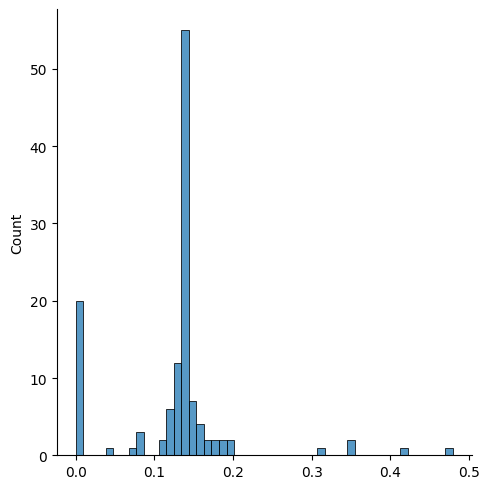

In [8]:
sns.displot(symmetric_info, bins=50)

In [10]:
len(symmetric_info)

124

In [11]:
train_df = pd.concat([X_train, y_train], axis=1)

In [12]:
df_minority = train_df[train_df.label.astype(float)==0]
df_majority = train_df[train_df.label.astype(float)==1]

In [13]:
df_majority_undersampled = resample(df_majority, 
                                     replace=False,
                                     n_samples=len(df_minority),
                                     random_state=42)
train_df_balanced = pd.concat([df_majority_undersampled, df_minority])

In [14]:
X_train=train_df_balanced.drop(['label'], axis=1)
y_train=train_df_balanced['label']

In [15]:
X_train.shape

(9842, 124)

In [27]:
def function_maofs_1(x, X_train=X_train.values, y_train=y_train.values.astype(float), X_test=X_val.values, y_test=y_val.values.astype(float), mutual_info=symmetric_info, estimator=GaussianNB()):
    x = np.array(x, dtype=bool)
    feature_costs=np.ones(X_train.shape[1])

    def validation(x, X_train, y_train, X_test, y_test, estimator):
        clf = clone(estimator)
        if all(not element for element in x):
            metrics = metrics1 = 0
            return metrics, metrics1
        else:
            clf.fit(X_train[:, x], y_train)
            y_pred = clf.predict(X_test[:, x])
            metrics = recall_score(y_test, y_pred, average='macro', zero_division=1)
            metrics1 = f1_score(y_test, y_pred, labels=list(set(y_train)), average='macro', zero_division=1)
            metrics2 = accuracy_score(y_test, y_pred)
            # metrics1 = f1_score(y_test, y_pred, labels=list(set(y_train.values)), average='macro')

            return metrics, metrics1, metrics2
       
    scores, scores1, scores2 =  validation(x, X_train, y_train, X_test, y_test, estimator)

    costs_selected = []
    feature_costs = np.array(feature_costs)
    costs_selected = feature_costs[np.argwhere(x==True)]
    cost_sum = sum(costs_selected)/sum(feature_costs)
    mutual_info = np.array(mutual_info)
    mutual_info_costs = sum(mutual_info[np.argwhere(x==True)])/sum(mutual_info)
   
    if cost_sum == 0:
        f1, f2, f3, f4, f5 = 0, 0, 0, 0, 0
    else:
        f1 = -1 * scores
        f2 = cost_sum
        f2 = 1 * f2[0]
        f3 = mutual_info_costs
        f3 = -1 * f3[0]
        f4 = -1 * scores1
        f5 = -1 * scores2
        f1 = f1.item() #Specificity or Accuracy
        f2 = f2.item() #Number of features selected
        f3 = f3.item() #Symmetrical Uncentraintly
        f4 = f4.item() #Macro F1 Score
        f5 = f5.item() #Accuracy
        out = anp.column_stack(np.array([f1, f2, f3, f4, f5]))

    return f1, f2, f3, f4, f5

def function_maofs(x, X_train=X_train.values, y_train=y_train.values.astype(float), X_test=X_test.values, y_test=y_test.values.astype(float), mutual_info=symmetric_info, estimator=GaussianNB()):
    x = np.array(x, dtype=bool)
    feature_costs=np.ones(X_train.shape[1])

    def validation(x, X_train, y_train, X_test, y_test, estimator):
        clf = clone(estimator)
        if all(not element for element in x):
            metrics = metrics1 = 0
            return metrics, metrics1
        else:
            clf.fit(X_train[:, x], y_train)
            y_pred = clf.predict(X_test[:, x])
            metrics = recall_score(y_test, y_pred, average='macro', zero_division=1)
            metrics1 = f1_score(y_test, y_pred, labels=list(set(y_train)), average='macro', zero_division=1)
            # metrics2 = accuracy_score(y_test, y_pred)
            # metrics1 = f1_score(y_test, y_pred, labels=list(set(y_train.values)), average='macro')

            return metrics, metrics1 #, metrics2
       
    scores, scores1 =  validation(x, X_train, y_train, X_test, y_test, estimator)

    costs_selected = []
    feature_costs = np.array(feature_costs)
    costs_selected = feature_costs[np.argwhere(x==True)]
    cost_sum = sum(costs_selected)/sum(feature_costs)
    mutual_info = np.array(mutual_info)
    mutual_info_costs = sum(mutual_info[np.argwhere(x==True)])/sum(mutual_info)
   
    if cost_sum == 0:
        f1, f2, f3, f4 = 0, 0, 0, 0
    else:
        f1 = -1 * scores
        f2 = cost_sum
        f2 = 1 * f2[0]
        f3 = mutual_info_costs
        f3 = -1 * f3[0]
        f4 = -1 * scores1
#         f5 = -1 * scores2
        f1 = f1.item() #Specificity or Accuracy
        f2 = f2.item() #Number of features selected
        f3 = f3.item() #Symmetrical Uncentraintly
        f4 = f4.item() #Macro F1 Score
#         f5 = f5.item() #Accuracy
        out = anp.column_stack(np.array([f1, f2, f3, f4]))
    
    return f1, f2, f3, f4

In [19]:
def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

In [20]:
def nsga_ii(toolbox, seed, stats=None, verbose=False):
    pop = toolbox.population(n=toolbox.pop_size)
    pop = toolbox.select(pop, len(pop))
    random.seed(seed)
    return algorithms.eaMuPlusLambda(pop, 
                                     toolbox, 
                                     mu=toolbox.pop_size, 
                                     lambda_=toolbox.pop_size, 
                                     cxpb=toolbox.cross_prob,
                                     mutpb=toolbox.mut_prob,
                                     ngen=toolbox.max_gen,
                                     stats=stats, 
                                     verbose=verbose)

In [21]:
def nsga_iii(toolbox,seed,stats,NGEN,MU,CXPB,MUTPB):
    pop = toolbox.population(n=MU)
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    pop = toolbox.select(pop, len(pop))
    
    random.seed(seed)
    # Begin the generational process
    for gen in range(1, NGEN):
        offspring = algorithms.varAnd(pop, toolbox, CXPB, MUTPB)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        record = stats.compile(pop)
        print(record)

        # Select the next generation population
        pop = toolbox.select(pop + offspring, MU)
    
    return pop

In [28]:
NOBJ = 4
BOUND_LOW, BOUND_UP = 0.0, 1.0
MU = 120
NGEN = 100
CXPB = 0.8
MUTPB = 0.2

P = 4
ref_points = tools.uniform_reference_points(NOBJ, 4)
ref_point = ref_points.max(axis=0)
seed = 1

## Many-Objective Feature Selection

In [29]:
NDIM = X_train.shape[1]

creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ)
creator.create("Individual", list, fitness=creator.FitnessMin) 

toolbox = base.Toolbox()
toolbox.register("evaluate", function_maofs)

toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, NDIM)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [30]:
from pymoo.indicators.hv import HV
from pymoo.indicators.igd import IGD
from pymoo.indicators.gd import GD

gd = GD(ref_points)
igd = IGD(ref_points)
hv = HV(ref_point=ref_point)

In [25]:
toolbox.register("select", tools.selNSGA2)

toolbox.pop_size = MU
toolbox.max_gen = NGEN
toolbox.mut_prob = MUTPB
toolbox.cross_prob = CXPB

stats = tools.Statistics()
# stats.register("time", measure_time)

with open('deap_win10_fitness_nsgaii_tree.csv','w', newline='') as f, open('deap_win10_solution_nsgaii_tree.csv','w', newline='') as g, open('deap_win10_metrics_nsgaii_tree.csv','w', newline='') as h, open('deap_win10_evaluation_nsgaii_tree.csv','w', newline='') as i:
    writerFitness = csv.writer(f)
    writerFitness.writerow(["Recall","NFS","SU","MacroF1"])
    
    writerEval = csv.writer(i)
    writerEval.writerow(["Recall","NFS","SU","MacroF1","Acc"])
    
    writerMetric = csv.writer(h)
    writerMetric.writerow(["GD","IGD","HV"])
    
    writerPopulation = csv.writer(g)

    for j in range(10):
        res, logbook = nsga_ii(toolbox, seed=j, stats=stats, verbose=True)
        fronts = tools.emo.sortLogNondominated(res, len(res))
        for i, inds in enumerate(fronts):
            par = [toolbox.evaluate(ind) for ind in inds]
            df_fit = pd.DataFrame(par)
            df_sol = pd.DataFrame(res)

            writerMetric.writerow(anp.column_stack(np.array([gd(df_fit.values),
                                                             igd(df_fit.values),
                                                             hv(df_fit.values)])))
            for fitness in df_fit.values:
                writerFitness.writerow(fitness)
            for population in df_sol.values:
                writerPopulation.writerow(population)
                evaluation=function_maofs_1(population)
                writerEval.writerow(evaluation)

            writerMetric.writerow('\\n')
            writerFitness.writerow('\\n')
            writerPopulation.writerow('\\n')
            writerEval.writerow('\\n')
            print(j,' ')

gen	nevals
0  	120   
1  	120   
2  	120   
3  	120   
4  	120   
5  	120   
6  	120   
7  	120   
8  	120   
9  	120   
10 	120   
11 	120   
12 	120   
13 	120   
14 	120   
15 	120   
16 	120   
17 	120   
18 	120   
19 	120   
20 	120   
21 	120   
22 	120   
23 	120   
24 	120   
25 	120   
26 	120   
27 	120   
28 	120   
29 	120   
30 	120   
31 	120   
32 	120   
33 	120   
34 	120   
35 	120   
36 	120   
37 	120   
38 	120   
39 	120   
40 	120   
41 	120   
42 	120   
43 	120   
44 	120   
45 	120   
46 	120   
47 	120   
48 	120   
49 	120   
50 	120   
51 	120   
52 	120   
53 	120   
54 	120   
55 	120   
56 	120   
57 	120   
58 	120   
59 	120   
60 	120   
61 	120   
62 	120   
63 	120   
64 	120   
65 	120   
66 	120   
67 	120   
68 	120   
69 	120   
70 	120   
71 	120   
72 	120   
73 	120   
74 	120   
75 	120   
76 	120   
77 	120   
78 	120   
79 	120   
80 	120   
81 	120   
82 	120   
83 	120   
84 	120   
85 	120   
86 	120   
87 	120   
88 	120   
89 	120   

27 	120   
28 	120   
29 	120   
30 	120   
31 	120   
32 	120   
33 	120   
34 	120   
35 	120   
36 	120   
37 	120   
38 	120   
39 	120   
40 	120   
41 	120   
42 	120   
43 	120   
44 	120   
45 	120   
46 	120   
47 	120   
48 	120   
49 	120   
50 	120   
51 	120   
52 	120   
53 	120   
54 	120   
55 	120   
56 	120   
57 	120   
58 	120   
59 	120   
60 	120   
61 	120   
62 	120   
63 	120   
64 	120   
65 	120   
66 	120   
67 	120   
68 	120   
69 	120   
70 	120   
71 	120   
72 	120   
73 	120   
74 	120   
75 	120   
76 	120   
77 	120   
78 	120   
79 	120   
80 	120   
81 	120   
82 	120   
83 	120   
84 	120   
85 	120   
86 	120   
87 	120   
88 	120   
89 	120   
90 	120   
91 	120   
92 	120   
93 	120   
94 	120   
95 	120   
96 	120   
97 	120   
98 	120   
99 	120   
100	120   
7  
gen	nevals
0  	120   
1  	120   
2  	120   
3  	120   
4  	120   
5  	120   
6  	120   
7  	120   
8  	120   
9  	120   
10 	120   
11 	120   
12 	120   
13 	120   
14 	120   
15 	12

In [31]:
toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

toolbox.pop_size = MU
toolbox.max_gen = NGEN
toolbox.mut_prob = MUTPB
toolbox.cross_prob = CXPB

stats = tools.Statistics()
# stats.register("time", measure_time)

with open('deap_win10_fitness_nsgaiii_tree.csv','w', newline='') as f, open('deap_win10_solution_nsgaiii_tree.csv','w', newline='') as g, open('deap_win10_metrics_nsgaiii_tree.csv','w', newline='') as h, open('deap_win10_evaluation_nsgaiii_tree.csv','w', newline='') as i:
    writerFitness = csv.writer(f)
    writerFitness.writerow(["Recall","NFS","SU","MacroF1"])
    
    writerEval = csv.writer(i)
    writerEval.writerow(["Recall","NFS","SU","MacroF1","Acc"])
    
    writerMetric = csv.writer(h)
    writerMetric.writerow(["GD","IGD","HV"])
    
    writerPopulation = csv.writer(g)

    for j in range(10):
        res = nsga_iii(toolbox,seed,stats,NGEN,MU,CXPB,MUTPB)
        fronts = tools.emo.sortLogNondominated(res, len(res))
        for i, inds in enumerate(fronts):
            par = [toolbox.evaluate(ind) for ind in inds]
            df_fit = pd.DataFrame(par)
            df_sol = pd.DataFrame(res)
            
            writerMetric.writerow(anp.column_stack(np.array([gd(df_fit.values),
                                                             igd(df_fit.values),
                                                             hv(df_fit.values)])))
            for fitness in df_fit.values:
                writerFitness.writerow(fitness)
            for population in df_sol.values:
                writerPopulation.writerow(population)
                evaluation=function_maofs_1(population)
                writerEval.writerow(evaluation)

            writerMetric.writerow('\\n')
            writerFitness.writerow('\\n')
            writerPopulation.writerow('\\n')
            writerEval.writerow('\\n')
            print(j,' ')

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
0  
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
1  
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
2  
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{

In [208]:
with open('deap_win7_evaluation_nsgaii_Tree.csv','w', newline='') as i:
    df = pd.read_csv('deap_win7_solution_nsgaii_Tree.csv')
    writerEval = csv.writer(i)
    writerEval.writerow(["Recall","NFS","SU","MacroF1","Acc"])
    
    for i in range(0, df.values.shape[0]):
        if df.values[i][0] == '\\':
            writerEval.writerow('\\n')
        else:
            evaluation = function_maofs_1(df.values[i].astype(int))
            writerEval.writerow(evaluation)

[0 0 0 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1
 1 0 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0
 1 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
[0 0 0 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1
 1 0 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1
 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0]
[0 0 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1
 1 0 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 1 0 1 1
 0 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 1 0 0 0 1
 0 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 0]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1
 0 0 1 0 0 0 1 0 0 0 0 0 1 1 1 0 1 1 1 1 0]
[0 0 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1
 1 0 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 

[0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1
 1 0 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0]
[0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 0 1 1
 1 0 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0]
[0 0 0 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0
 1 1 1 1 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 1 0 1 0
 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 

[0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 1 0 1 1
 0 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0]


## ZDT 6

In [45]:
NDIM = 10

creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ) # for minimization
creator.create("Individual", list, fitness=creator.FitnessMin) 

toolbox = base.Toolbox()

toolbox.register("evaluate", zdt6) #Fitness Function

#Chromosome representation Real Valued
toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM) 
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [47]:
toolbox.register("select", tools.selNSGA2)

toolbox.pop_size = MU
toolbox.max_gen = NGEN
toolbox.mut_prob = MUTPB
toolbox.cross_prob = CXPB

stats = tools.Statistics()
stats.register("time", measure_time)

with open('deap_time_nsga2_zdt6_100_500_2_10.csv', 'w', newline='') as file:   
    writer = csv.writer(file)
    writer.writerow(["Execution Time"])
    
    start_time = time.time()
    res, logbook = nsga_ii(toolbox, seed=seed, stats=stats, verbose=True)
    
    fronts = tools.emo.sortLogNondominated(res, len(res))
    
    for i, inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)
        
    df.to_csv('deap_fitness_nsga2_zdt6_100_500_2_10.csv', index=False)

gen	nevals	time      
0  	100   	0.00299239
1  	100   	0.0592997 
2  	100   	0.0987339 
3  	100   	0.13364   
4  	100   	0.168547  
5  	100   	0.204009  
6  	100   	0.237167  
7  	100   	0.270079  
8  	100   	0.305983  
9  	100   	0.340891  
10 	100   	0.382848  
11 	100   	0.417684  
12 	100   	0.450596  
13 	100   	0.481513  
14 	100   	0.522404  
15 	100   	0.559305  
16 	100   	0.594251  
17 	100   	0.628191  
18 	100   	0.671008  
19 	100   	0.716885  
20 	100   	0.763759  
21 	100   	0.804686  
22 	100   	0.837604  
23 	100   	0.872198  
24 	100   	0.916014  
25 	100   	0.962888  
26 	100   	1.00677   
27 	100   	1.06462   
28 	100   	1.09952   
29 	100   	1.13148   
30 	100   	1.17897   
31 	100   	1.21088   
32 	100   	1.24281   
33 	100   	1.27964   
34 	100   	1.31156   
35 	100   	1.34248   
36 	100   	1.3724    
37 	100   	1.41023   
38 	100   	1.44521   
39 	100   	1.47715   
40 	100   	1.50909   
41 	100   	1.54197   
42 	100   	1.57195   
43 	100   	1.60205   
44 	100   

376	100   	19.5463   
377	100   	19.6084   
378	100   	19.6698   
379	100   	19.7182   
380	100   	19.7623   
381	100   	19.8094   
382	100   	19.847    
383	100   	19.8917   
384	100   	19.942    
385	100   	19.99     
386	100   	20.0333   
387	100   	20.0684   
388	100   	20.1065   
389	100   	20.1506   
390	100   	20.1843   
391	100   	20.2232   
392	100   	20.2593   
393	100   	20.3002   
394	100   	20.3328   
395	100   	20.3695   
396	100   	20.4095   
397	100   	20.4519   
398	100   	20.494    
399	100   	20.5388   
400	100   	20.5969   
401	100   	20.6633   
402	100   	20.7293   
403	100   	20.7911   
404	100   	20.8515   
405	100   	20.8893   
406	100   	20.9228   
407	100   	20.9647   
408	100   	21.0037   
409	100   	21.04     
410	100   	21.0726   
411	100   	21.1096   
412	100   	21.1505   
413	100   	21.19     
414	100   	21.2224   
415	100   	21.2593   
416	100   	21.3034   
417	100   	21.3499   
418	100   	21.3905   
419	100   	21.4268   
420	100   	21.466    
421	100   

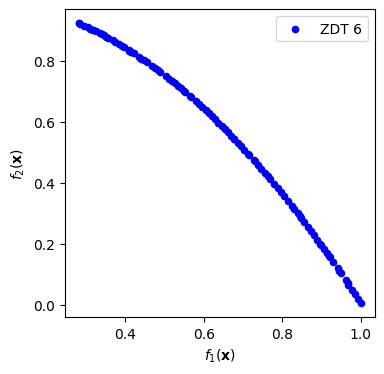

In [51]:
plot_colors = ('b','r', 'g', 'm', 'y', 'k', 'c')
fig, ax = plt.subplots(1, figsize=(4,4))

df.plot(ax=ax, kind='scatter', label='ZDT 6', 
        x=df.columns[0], y=df.columns[1], 
        color=plot_colors[i % len(plot_colors)])
plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$');

In [50]:
toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

stats = tools.Statistics()
stats.register("time", measure_time)

with open('deap_time_nsga3_zdt6_100_500_2_10.csv', 'w', newline='') as file:   
    writer = csv.writer(file)
    writer.writerow(["Execution Time"])
    
    start_time = time.time()
    res = nsga_iii(toolbox,seed,stats,NGEN,MU,CXPB,MUTPB)
    
    fronts = tools.emo.sortLogNondominated(res, len(res))
    
    for i, inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)
        
    df.to_csv('deap_fitness_nsga3_zdt6_100_500_2_10.csv', index=False)

{'time': 0.01765751838684082}
{'time': 0.04672360420227051}
{'time': 0.05999565124511719}
{'time': 0.0733025074005127}
{'time': 0.0797586441040039}
{'time': 0.087066650390625}
{'time': 0.09629249572753906}
{'time': 0.10149216651916504}
{'time': 0.10841202735900879}
{'time': 0.11245369911193848}
{'time': 0.11964559555053711}
{'time': 0.12570762634277344}
{'time': 0.13183879852294922}
{'time': 0.14126372337341309}
{'time': 0.15286922454833984}
{'time': 0.16067099571228027}
{'time': 0.16695952415466309}
{'time': 0.17632842063903809}
{'time': 0.18547415733337402}
{'time': 0.19054865837097168}
{'time': 0.19661855697631836}
{'time': 0.2006230354309082}
{'time': 0.2067258358001709}
{'time': 0.21547937393188477}
{'time': 0.21949005126953125}
{'time': 0.22800827026367188}
{'time': 0.24236297607421875}
{'time': 0.2525956630706787}
{'time': 0.26125097274780273}
{'time': 0.2677948474884033}
{'time': 0.27301788330078125}
{'time': 0.27655553817749023}
{'time': 0.2857339382171631}
{'time': 0.29224538

{'time': 2.7103068828582764}
{'time': 2.7178616523742676}
{'time': 2.7294609546661377}
{'time': 2.7379443645477295}
{'time': 2.7454042434692383}
{'time': 2.7525670528411865}
{'time': 2.756127119064331}
{'time': 2.7664334774017334}
{'time': 2.775182008743286}
{'time': 2.7820241451263428}
{'time': 2.7911126613616943}
{'time': 2.7996959686279297}
{'time': 2.8068132400512695}
{'time': 2.814300775527954}
{'time': 2.821566343307495}
{'time': 2.826357126235962}
{'time': 2.83559513092041}
{'time': 2.8420567512512207}
{'time': 2.8499321937561035}
{'time': 2.8553152084350586}
{'time': 2.8644421100616455}
{'time': 2.8705894947052}
{'time': 2.885082483291626}
{'time': 2.8999836444854736}
{'time': 2.9170138835906982}
{'time': 2.9380459785461426}
{'time': 2.9563300609588623}
{'time': 2.975748062133789}
{'time': 2.990983486175537}
{'time': 3.007059097290039}
{'time': 3.0206446647644043}
{'time': 3.0361502170562744}
{'time': 3.0539042949676514}
{'time': 3.071697473526001}
{'time': 3.0882437229156494}
